In [787]:
import pysam
import pysamstats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# https://github.com/alimanfoo/pysamstats

### example bam file and reference

In [202]:
bam = '/projects/analysis/analysis30/A78402/merge24659_bwa-mem-0.7.6a-sb/150nt/hg19a/A78402_7_lanes_dupsFlagged.bam'
ref = '/home/pubseq/genomes/Homo_sapiens/hg19a/bwa_ind/genome/GRCh37-lite.fa'

In [283]:
mybam = pysam.AlignmentFile(bam)
X = []
for rec in pysamstats.stat_variation(mybam, chrom=chrom, start=pos-150, end=pos+150, fafile=ref, pad=True, truncate=True):
    X.append([rec['chrom'], rec['pos'], rec['ref'], rec['matches'], rec['mismatches']])

below extract stats for 298 ref bases, we are trying to determine if position 149 is a true mutation4

In [26]:
# %%bash -s $ref $bam 
# pysamstats --fasta $1 --type variation --chromosome 5 --start 1295228 --end 1295229  $2 > sample.pysamstats.out


In [27]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/notebook/sample.pysamstats.out'
df = pd.read_csv(f, sep='\t')
df.head(2)

,chrom,pos,ref,reads_all,reads_pp,matches,matches_pp,mismatches,mismatches_pp,deletions,...,A,A_pp,C,C_pp,T,T_pp,G,G_pp,N,N_pp
0,5,1295080,C,1,1,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,5,1295081,T,1,1,1,1,0,0,0,...,0,0,0,0,1,1,0,0,0,0


the goal is to classify if this is a true mutation at row 149 based on the read support

#### a false positive example

In [29]:
bam = '/projects/analysis/analysis22/A38440/merge_bwa-mem-0.7.6a/125nt/hg19a/A38440_4_lanes_dupsFlagged.bam'
bam = '/projects/analysis/analysis26/A62911/merge_bwa-mem-0.7.6a/150nt/hg19a/A62911_2_lanes_dupsFlagged.bam'
chrom = 10
pos = 121482006


end = pos + 1

In [507]:
a = pysamstats.load_variation(mybam, chrom=chrom, start=pos-150, end=pos+150, fafile=ref, pad=True, truncate=True)

In [509]:
a.dtype.names

('chrom',
 'pos',
 'ref',
 'reads_all',
 'reads_pp',
 'matches',
 'matches_pp',
 'mismatches',
 'mismatches_pp',
 'deletions',
 'deletions_pp',
 'insertions',
 'insertions_pp',
 'A',
 'A_pp',
 'C',
 'C_pp',
 'T',
 'T_pp',
 'G',
 'G_pp',
 'N',
 'N_pp')

In [578]:
def get_basecounts(chrom, pos, bam):
    mybam = pysam.AlignmentFile(bam)
    a = pysamstats.load_variation(mybam, chrom=chrom, start=pos-150, end=pos+150, fafile=ref, pad=True, truncate=True)
    # returns a structured array
    bs = a[['chrom', 'pos', 'ref', 'A', 'T', 'C', 'G']]
    df = pd.DataFrame(bs)
    df['chrom'] = df['chrom'].apply(lambda x: x.decode('utf-8'))
    df['ref'] = df['ref'].apply(lambda x: x.decode('utf-8'))
#     for i in 'ATCG':
#         df[i] = df[i].astype(int)
    x = df.apply(lambda x: normalize_counts(x.A, x['T'], x.C, x.G), axis=1)
    return x.tolist()

In [579]:
def normalize_counts(a, t, c, g):
#     print(type(a), type(t), type(c), type(g))
    tot = a + t + c + g
    if tot >= 10:
        pa = a / tot
        pt = t / tot
        pc = c / tot
        pg = g / tot
    else:
        pa, pt, pc, pg = np.nan, np.nan, np.nan, np.nan
    return [pa, pt, pc, pg]

In [588]:
x = get_basecounts(chrom, pos, bam)
df = pd.DataFrame(x, columns=['A', 'T', 'C', 'G'])

In [30]:
%%bash -s $ref $bam $chrom $pos $end
pysamstats --fasta $1 --type variation --chromosome $3 --start $4  --end $5  $2 > sample2.pysamstats.out

In [31]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/notebook/sample2.pysamstats.out'
df = pd.read_csv(f, sep='\t')
df.head(2)

,chrom,pos,ref,reads_all,reads_pp,matches,matches_pp,mismatches,mismatches_pp,deletions,...,A,A_pp,C,C_pp,T,T_pp,G,G_pp,N,N_pp
0,10,121481858,A,2,2,2,2,0,0,0,...,2,2,0,0,0,0,0,0,0,0
1,10,121481859,G,3,3,3,3,0,0,0,...,0,0,0,0,0,0,3,3,0,0


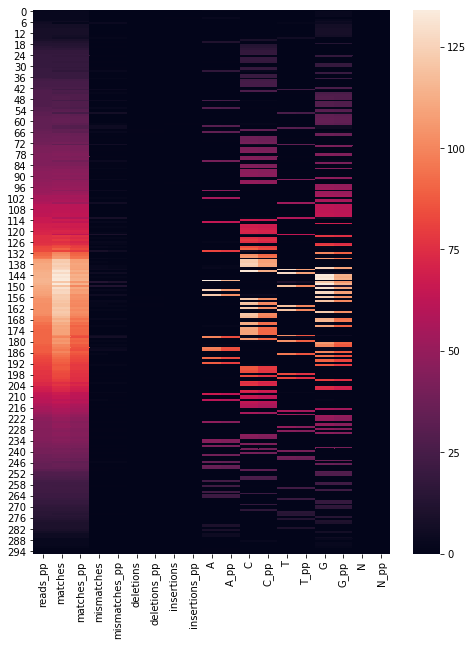

In [32]:
fig = plt.figure(figsize=(8,10)) 
ax = fig.add_subplot(111)
sns.heatmap(df[df.columns[4:]])

In [583]:
refs = pd.DataFrame(df['ref'].map({'A':1, 'T':2, 'C':3, 'G':4}))

KeyError: 'ref'

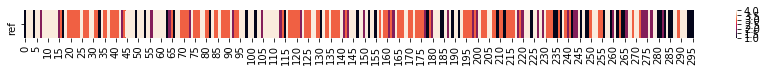

In [34]:
fig = plt.figure(figsize=(15,.5)) 
ax = fig.add_subplot(111)
sns.heatmap(refs.T)

In [591]:
cols = ['A', 'T', 'C', 'G']
clrs = ['Greens', 'Reds', 'Blues', 'Greys']

In [590]:
df[['A', 'T', 'C', 'G']].T

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
A,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
G,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [592]:
color_dict = {'A':'green', 'T':'red', 'C':'blue', 'G':'black'}

In [593]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [594]:
cats = ['A', 'T', 'C', 'G']
_, clrmap = make_cmap_for_heatmap(cats, color_dict)

In [595]:
def remove_axes(ax):
    _ = plt.setp(ax.get_yticklines(), visible=False)
    _ = plt.setp(ax.get_xticklines(), visible=False)
    _ = plt.setp(ax.get_xticklabels(), visible=False)
    _ = ax.set_xticklabels('')

Basically, igv review process can be modeled as quantitative mearsure background cleaness, i don't need to worry about the variants to be reviewed since this can be simply handled by the percentage of alternative alleles and coverage either upstream or downstream.

can zero value be plotted as white? easier for image recognition
need to normalize the color based on percentage ? so that the some extremely high coverage will not distort the picture. it seems replace 0 to np.nan do the trick

In [597]:
dfo = df

0.0
1.0
0.1
1.0
0.2
1.0
0.30000000000000004
1.0


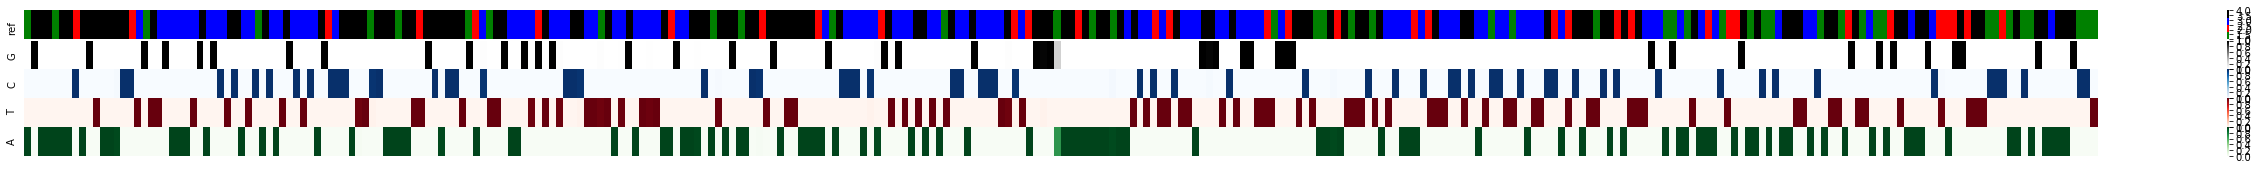

In [598]:
#Creating a new full window axes
import numpy as np
from matplotlib import style, colors
for i, col, clr in zip(np.arange(0,0.4,0.1), cols, clrs):
    print(i)
    ax = plt.axes((0, i+.05, 6, .1), facecolor='w')
    remove_axes(ax)
    data = dfo[[col]].T
    mx = data.max().max()
    print(mx)
    sns.heatmap(data, vmin=0, vmax=mx, cmap=clr)
# plt.axes((1,3,2,.5), facecolor='y')
# #Creating a new axes with specified dimensions and some kwargs
ax_ref = plt.axes((0, 0.455, 6, .1), facecolor='w')
remove_axes(ax_ref)
sns.heatmap(refs.T, ax=ax_ref,cmap=clrmap)
of = 'example_image_for_recognition.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

### try naive Bayes model first

Here I first would like to try Naive Bayes generative alogrithm because it is relatively easy to implement and also often works surprisingly well.

features is represented as a vector of base mismatch rate of 300ish bases. I tend to exclude the variant position since my goal is actually to gauge the cleanness of the background. Therefore, input vector $X = [x_1, x_2, ..., x_n]$, n = 300, $x_j$ is the base mismatch rate at $j^{th}$ position. the question here is how i could also take into account of base quality and mapping quality of the base. Maybe just append to X? 

We model the base mismatche distribution given y (P(x|y) for both true and false mutations in the training set. 

### make the input vector X

In [490]:
def get_misrate(chrom, pos, bam):
    mybam = pysam.AlignmentFile(bam)
    a = pysamstats.load_variation(mybam, chrom=chrom, start=pos-150, end=pos+150, fafile=ref, pad=True, truncate=True)
    # returns a structured array
    bs = a[['chrom', 'pos', 'ref', 'matches', 'mismatches']]
    df = pd.DataFrame(bs)
    df['chrom'] = df['chrom'].apply(lambda x: x.decode('utf-8'))
    df['ref'] = df['ref'].apply(lambda x: x.decode('utf-8'))
    x = df.apply(lambda x: mismatch_rate(x.matches, x.mismatches), axis=1)
    return x.tolist()

In [491]:
def mismatch_rate(matches, mismatches):
    '''
    this func will take care of no or low coverage cases later
    '''
    total = matches + mismatches
    if total >= 10:
        mis_rate = mismatches/float(total)
    else: 
        mis_rate = np.nan
        print('coverage < 10')
    return mis_rate

In [492]:
# df['mis_rate'] = df[['matches', 'mismatches']].apply(lambda x: mismatch_rate(x.matches, x.mismatches), axis=1)

In [190]:
# X = np.array(df['mis_rate'])

### generate a bunch of false positive examples

In [493]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/rainstorm/all_rainstorm_hotspots_reviewed_from_wei_20190403.csv'
df3 = pd.read_csv(f3, sep='\t')
cols = ['chr', 'start_x','is_real', 'Tumour bams', 'Normal bams']
df3 = df3[cols]
df3.head()

,chr,start_x,is_real,Tumour bams,Normal bams
0,6,142706206,yes,/projects/analysis/analysis22/A37261/merge_bwa...,/projects/analysis/analysis22/A37189/merge_bwa...
1,6,142706209,yes,/projects/analysis/analysis22/A37261/merge_bwa...,/projects/analysis/analysis22/A37189/merge_bwa...
2,5,1295228,yes,/projects/analysis/analysis22/A37243/merge_bwa...,/projects/analysis/analysis22/A37168/merge_bwa...
3,5,1295250,yes,/projects/analysis/analysis22/A54376/merge_bwa...,/projects/analysis/analysis21/A54481/merge_bwa...
4,10,31446950,no,/projects/analysis/analysis22/A38440/merge_bwa...,/projects/analysis/analysis22/A37951/merge_bwa...


In [500]:
df3.loc[df3[df3.chr == 23].index, 'chr'] = 'X'
df_real = df3[df3.is_real == 'yes']
df_false = df3[df3.is_real == 'no']

In [482]:
# df_false['chr'] = df_false.chr.replace(23, 'X')
# df_false.loc[23, 'chr'] = X

In [502]:
def proc_snvs(df, lb):
    X = []
    for ix, row in df.iterrows():
        chrom =  str(row.chr)
        bams = row['Tumour bams'].split(';')
        pos = row.start_x
        for bam in bams:
    #         print(chrom, pos, bam)
            x = get_misrate(chrom, pos, bam)
            X.append(x)
    # drop the position with the mutations
    dfo = pd.DataFrame(X).drop(149, axis=1).round(3)
    df_fix = fix_lowcoverage(dfo)
    arr = add_label(df_fix, lb)
    return arr

In [503]:
# fill positions with insufficient coverage with the local average mismatch rate
def fix_lowcoverage(df):
    Y = []
    for ix, row in df.iterrows():
        if row.isna().any():
            avg = row.mean()
            row = row.fillna(avg)
        Y.append(row)
    return pd.DataFrame(Y).dropna()

In [504]:
def add_label(df, lb):
    df['label'] = lb
    return df.to_numpy()

In [505]:
poss = proc_snvs(df_real, 1)

In [506]:
negs = proc_snvs(df_false, 0)

coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
coverage < 10
covera

In [607]:
negs

array([[0.        , 0.        , 0.        , ..., 0.        , 0.014     ,
        0.        ],
       [0.015     , 0.        , 0.028     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00345211, 0.00345211,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00280077, 0.00280077,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00440996, 0.00440996,
        0.        ]])

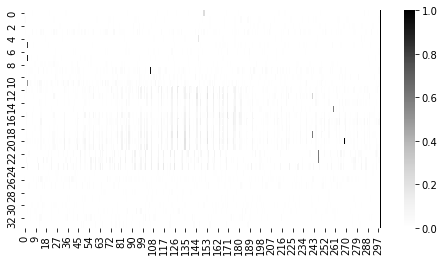

In [601]:
f, ax = plt.subplots(figsize=(8,4))
sns.heatmap(poss, cmap='Greys')


In [655]:
combined = np.concatenate((poss, negs), axis=0)

In [609]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/ml_autoreview/training_examples.txt'
np.savetxt(of, combined)

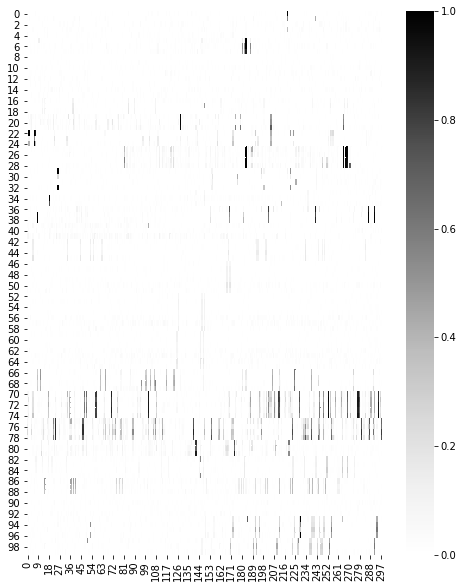

In [603]:
f, ax = plt.subplots(figsize=(8,10))
sns.heatmap(negs[:100], cmap='Greys')

### use a logistic model:

#### split data into train and val

In [633]:
from sklearn.model_selection import train_test_split
# Optimization module in scipy
from scipy import optimize

In [656]:
X = combined[:,:-1]
y = combined[:,-1]

In [805]:
# Add intercept term to X
m = y.size
X = np.concatenate([np.ones((m, 1)), X], axis=1)

In [807]:
X.shape

(1611, 300)

In [808]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [809]:
# labels are imbalanced in the training set
(combined[:, -1] == 1).sum()
(combined[:, -1] == 0).sum()

34

1577

In [810]:
X_train.shape, y_test.shape

((1079, 300), (532,))

In [811]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================

    g = 1/(1 + np.exp(-z))

    # =============================================================
    return g

In [812]:
def computeCostReg(X, y, theta, lambda_):      
    # number of training examples
    m = y.size  
    theta = np.array(theta)
    J = 1/m*np.sum(-y@np.log(sigmoid(X@theta))-(1-y)@np.log(1-sigmoid(X@theta))) + lambda_/2/m*np.sum(theta[1:]**2)
    return J

In [813]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    theta = np.array(theta)
#     print('theta xxxx,', theta, type(theta))
#     print(theta.shape)
    grad = np.zeros(theta.shape)
#     print(grad, grad.shape)

    # ===================== YOUR CODE HERE ======================
#     X = np.concatenate([np.ones([m,1]), X], axis=1) # ones concatenated to X by mapFeature function
    J = 1/m*np.sum(-y@np.log(sigmoid(X@theta))-(1-y)@np.log(1-sigmoid(X@theta))) + lambda_/2/m*np.sum(theta[1:]**2)
#     print(J)
    n = grad.shape[0]
    grad[0] = 1/m*np.sum((sigmoid(X@theta) - y)@X[:,0])
    for j in range(n-1):
        j += 1
  
        grad[j] = 1/m*np.sum((sigmoid(X@theta) - y)@X[:,j]) + lambda_/m*theta[j]
    
    
    # =============================================================
    return J, grad

In [814]:
# not sure if this is absolutely right, but just want to see if cost goes down
def gradientDescent(X, y, theta, alpha, labmda_, num_iters):   
    m = y.shape[0]  # number of training examples
    theta = theta.copy()
    J_history = [] 
    theta_history = []
#     print('intial theta is', theta, type(theta), theta.shape)
    for i in tqdm(range(num_iters)):        
        # must update thetas simultaneously
        theta_tmp = []    
        for j in range(len(theta)): # partial derivative 
            gradient = (alpha/m) * np.sum(((X @ theta) - y) * X[:,j])
            new_theta = theta[j] - gradient
            theta_tmp.append(new_theta)        
        theta = theta_tmp
        theta_history.append(theta_tmp)
        
        J_history.append(computeCostReg(X, y, theta, lambda_))
    # add in the intial theta and cost
    theta_history = [init_theta.tolist()] + theta_history
    J_history = [costFunctionReg(theta, X, y, lambda_)[0]] + J_history
    return theta, J_history, theta_history

In [847]:
# initialize fitting parameters, when should i use 0, or 1, or random values
# theta = np.zeros(2)
# theta = np.ones(2)
init_theta = np.ones(X_train.shape[1])
# some gradient descent settings
iterations = 20000
alpha = 0.01
lambda_ = 1

theta, J_history, theta_history = gradientDescent(X_train, y_train, init_theta, alpha, lambda_, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))
theta_history[:2]

100%|██████████| 20000/20000 [5:55:22<00:00,  9.00it/s]  


Theta found by gradient descent: -0.1036, 0.3812


[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,

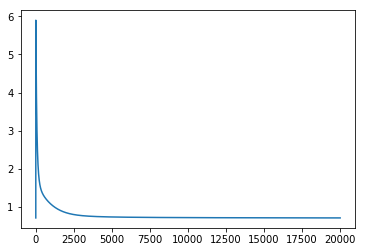

In [848]:
plt.plot(J_history)
# plt.xlim(1000, 2000)

In [636]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    prob = sigmoid(X@theta)
    p = prob >= 0.5
    
    
    # ============================================================
    return p

In [676]:
np.where(combined[:,-1] ==1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

In [832]:
combined.shape
xx.shape

(1611, 300)

NameError: name 'xx' is not defined

In [834]:
np.ones((m, 1)),
X = np.concatenate([np.ones((m, 1)), X], axis=1)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [849]:
#  Predict probability for a student with score 45 on exam 1 
#  and score 85 on exam 2 
m = combined.shape[0]
xx = np.concatenate([np.ones((m, 1)), combined], axis=1)
for x in xx[:30,:-1]:
    prob = sigmoid(np.dot(x, theta))
    print('we predict probability of {:.3f}'.format(prob))


# Compute accuracy on our training set
p = predict(theta, X_train)
print('Train Accuracy: {:.2f} %'.format(np.mean(p == y_train) * 100))

we predict probability of 0.485
we predict probability of 0.473
we predict probability of 0.478
we predict probability of 0.511
we predict probability of 0.491
we predict probability of 0.627
we predict probability of 0.477
we predict probability of 0.642
we predict probability of 0.492
we predict probability of 0.509
we predict probability of 0.496
we predict probability of 0.604
we predict probability of 0.553
we predict probability of 0.562
we predict probability of 0.535
we predict probability of 0.559
we predict probability of 0.556
we predict probability of 0.559
we predict probability of 0.562
we predict probability of 0.583
we predict probability of 0.586
we predict probability of 0.553
we predict probability of 0.518
we predict probability of 0.533
we predict probability of 0.533
we predict probability of 0.486
we predict probability of 0.506
we predict probability of 0.486
we predict probability of 0.477
we predict probability of 0.485
Train Accuracy: 49.03 %


In [705]:
X.shape
X_train.shape

(1611, 299)

(1079, 299)

In [748]:
# Initialize fitting parameters
initial_theta = np.zeros(X_train.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 1

# set options for optimize.minimize
options= {'maxiter': 50}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (X_train, y_train, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

# utils.plotDecisionBoundary(plotData, theta, X, y)
# _ =pyplot.xlabel('Microchip Test 1')
# _ =pyplot.ylabel('Microchip Test 2')
# _ =pyplot.legend(['y = 1', 'y = 0'])
# _ =pyplot.grid(False)
# _ =pyplot.title('lambda = %0.2f' % lambda_)

0.693147180559945
0.69314718026136
0.6931471805525615
0.34575296069408706
0.26532561927212894
0.2653256171809758
0.26532561907005753
0.2653256192496689
0.240634697734836
0.2406346970072348
0.2406346976025508
0.24063469770528972
0.23427109312038147
0.23427109309623376
0.23427109311398175
0.23427109310656308
0.23427109304379123
0.23427109307262395
0.23427109311881789
0.2284218785511137
0.22713745179570427
0.22367292926067092
0.2236729286204694
0.22367292798690538
0.22367292919407922
0.2197947214164666
0.21979472099430092
0.21979472131765582
0.21976372479152761
0.21976372478758988
0.2197637247861993
0.21976372477186396
0.21976372446793366
0.2197637246546839
0.21962359948893292
0.21962359947831778
0.2196235994812261
0.2196235994857205
0.21962359948844992
0.21962179494573952
0.21962179494108663
0.21962179494532394
0.21962179250839542
0.21962179250839542


In [850]:
# Compute accuracy on our training set
p = predict(theta, X_train)

print('Train Accuracy: %.1f %%' % (np.mean(p == y_train) * 100))


Train Accuracy: 49.0 %


In [851]:
# Compute accuracy on our test set
p = predict(theta, X_test)

print('Test Accuracy: %.1f %%' % (np.mean(p == y_test) * 100))

Test Accuracy: 42.5 %
